# Performance Benchmarking of Zero-Shot Models in Classifying Emails

Before creating a zero-shot model aimed specifically towards classifying emails, we will bechmark the performance of two general zero-shot models created by Mortiz Laruer. He details the methodology of creating these general zero-shot models in his paper: ["Building Efficient Universal Classifiers with Natural Language Inference" (2023)](http://arxiv.org/abs/2312.17543).

We will be testing his DeBERTa and RoBERTa based zero-shot models from hugging face. Links to these models can be found here:

[MoritzLaurer/deberta-v3-large-zeroshot-v1.1-all-33](https://huggingface.co/MoritzLaurer/deberta-v3-large-zeroshot-v2.0)

[MoritzLaurer/roberta-large-zeroshot-v2.0](https://huggingface.co/MoritzLaurer/roberta-large-zeroshot-v2.0)

## What are zero-shot models?

Zero-shot classifiers or universal classifiers are machine learning models that have been trained on a set of labeled data but then is also able to classify new data on classes it has never seen before. In the context of text classfication, a zero-shot model can be given a piece of example text and an array of possible class names and is expected to return an array of confidence scores for each possible class (most often an array of floats ranging from 0.0-1.0).  

For example, given the following text and possible class names we would get the following confidence scores:

Input Text:
"Last week I upgraded my iOS version and ever since then my phone has been overheating whenever I use your app."

Input Class Names: [mobile, website, billing, account access]

Output Confidence Scores: [0.980, 0.011, 0.005, 0.003]

In this instance, the zero-shot model believes that the input text is most correlated with the class of "mobile". In the context of email classification, this would allow us to categorize emails based on the content their subject lines and/or message bodies.


## Benchmark Dataset

The above huggingface models were tested on a mixture of synthetically generated data and two commercially-friendly NLI datasets (MNLI, FEVER-NLI). To test their performance in classifying emails, we will utilize UC Berkley's Enron Email Analysis dataset which contains a subset of 1700 labeled email messages from the Eron email corpus. These labled emails have a variety of annotations. The type we are interested in is the primary topics annotation with provides 13 possible classes that an email can be labeled with.

The dataset and class names can be found here:
[UC Berkley Enron Email Analysis](https://bailando.berkeley.edu/enron_email.html)

After downloading the dataset, you will find the following folder structure:

<pre>
enron_with_categories
├── categories.txt
├── 1
    ├── email_thread_1.txt
    ├── email_thread_1.cats
    ├── email_thread_2.txt
    ├── email_thread_2.cats
    ├── email_thread_3.txt
    ├── email_thread_3.cats
    ├── ...
├── 2
├── 3
├── ...
</pre>

The categories.txt file contains all the possible class names as well as other annotations such as emotional tone. There are 8 top-level folder pertaining to the type of email thread that the folder contains (company business, personal email, logistics, empty message, etc.) This benchmark will only deal with email threads in the first folder - company business. Only these emails have been annotated with the primary topic label.

With regards to the primary topic label, there are 13 possible classes:
<pre>
3 Primary topics (if coarse genre 1.1 is selected)

3.1 regulations and regulators (includes price caps)
3.2 internal projects -- progress and strategy
3.3 company image -- current
3.4 company image -- changing / influencing
3.5 political influence / contributions / contacts
3.6 california energy crisis / california politics
3.7 internal company policy
3.8 internal company operations
3.9 alliances / partnerships
3.10 legal advice
3.11 talking points
3.12 meeting minutes
3.13 trip reports
</pre>

We can now plot the class distribution of this dataset.

In [3]:
# Read files from google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Array of classes
topics = [
    "regulations and regulators (includes price caps)",
    "internal projects -- progress and strategy",
    "company image -- current",
    "company image -- changing / influencing",
    "political influence / contributions / contacts",
    "california energy crisis / california politics",
    "internal company policy",
    "internal company operations",
    "alliances / partnerships",
    "legal advice",
    "talking points",
    "meeting minutes",
    "trip reports",
]

print(topics[0])
print(len(topics))

regulations and regulators (includes price caps)
13


In [5]:
# Read categories file
def get_email_thread_topics(email_thread):
  with open(email_thread) as f:
    # Print all lines
    lines = f.readlines()
    # print(lines)

    # Print only the lines starting with number 3
    email_thread_topics = []
    for line in lines:
      category = line.split(',')
      if category[0] == "3":
        # print(category)
        # Second number in category array is topic index
        email_thread_topics.append(topics[int(category[1]) - 1])

    # Create tuple of file and topics
    email_thread = (f.name, email_thread_topics)
    # print(email_thread)
    return email_thread_topics

print(get_email_thread_topics('/content/drive/My Drive/Gmail Extension Senior Project/enron_with_categories/1/6178.cats'))

['regulations and regulators (includes price caps)', 'california energy crisis / california politics']


In [6]:
# Read content file
def get_email_thread_content(email_thread):
  with open(email_thread) as f:
    return f.read()

print(get_email_thread_content('/content/drive/My Drive/Gmail Extension Senior Project/enron_with_categories/1/6178.txt'))

Message-ID: <2419450.1075840042358.JavaMail.evans@thyme>
Date: Fri, 11 May 2001 15:26:17 -0700 (PDT)
From: mike.swerzbin@enron.com
To: m..driscoll@enron.com
Subject: 
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Swerzbin, Mike </O=ENRON/OU=NA/CN=RECIPIENTS/CN=MSWERZB>
X-To: Driscoll, Michael M. </O=ENRON/OU=NA/CN=RECIPIENTS/CN=Mdrisc3>
X-cc: 
X-bcc: 
X-Folder: \ExMerge - Swerzbin, Mike\Sent Items
X-Origin: SWERZBIN-M
X-FileName: 

   BY MARK GOLDEN                                                               
   A DOW JONES NEWSWIRES COLUMN                                                 
                                                                                
   NEW YORK (DOW JONES)--THE CALIFORNIA SENATE IN SACRAMENTO PASSED A           
WINDFALL-PROFITS TAX ON SALES OF ELECTRICITY INTO THE STATE'S WHOLESALE         
ELECTRICITY MARKET MONDAY AFTERNOON AT 4:50 P.M. PDT. AT ALMOST EXACTLY THE SAME
TIME, CALIFORNIA INDEPE

In [7]:
# Read all files from directory
import os

In [8]:
email_threads_dir = '/content/drive/My Drive/Gmail Extension Senior Project/enron_with_categories/1/'

# Loop through all files in email threads directory
email_threads = []
for filename in os.listdir(email_threads_dir):
  if filename.endswith('.txt'): # Check if the file is a text file
    basename, _ = os.path.splitext(filename)
    email_content_path = os.path.join(email_threads_dir, basename + '.txt')
    email_topics_path = os.path.join(email_threads_dir, basename + '.cats')
    email_threads.append((email_content_path, email_topics_path))

# Print first 10 email thread tuples and number of email threads
print(email_threads[:10])
print(len(email_threads))

[('/content/drive/My Drive/Gmail Extension Senior Project/enron_with_categories/1/226952.txt', '/content/drive/My Drive/Gmail Extension Senior Project/enron_with_categories/1/226952.cats'), ('/content/drive/My Drive/Gmail Extension Senior Project/enron_with_categories/1/173928.txt', '/content/drive/My Drive/Gmail Extension Senior Project/enron_with_categories/1/173928.cats'), ('/content/drive/My Drive/Gmail Extension Senior Project/enron_with_categories/1/55205.txt', '/content/drive/My Drive/Gmail Extension Senior Project/enron_with_categories/1/55205.cats'), ('/content/drive/My Drive/Gmail Extension Senior Project/enron_with_categories/1/116661.txt', '/content/drive/My Drive/Gmail Extension Senior Project/enron_with_categories/1/116661.cats'), ('/content/drive/My Drive/Gmail Extension Senior Project/enron_with_categories/1/173978.txt', '/content/drive/My Drive/Gmail Extension Senior Project/enron_with_categories/1/173978.cats'), ('/content/drive/My Drive/Gmail Extension Senior Project

In [9]:
# Get email topics
all_email_topics = []
for email_thread in email_threads:
  email_topics = get_email_thread_topics(email_thread[1])
  all_email_topics.extend(email_topics)

# Print first 10 email topics
print(all_email_topics[:10])

['internal company operations', 'regulations and regulators (includes price caps)', 'alliances / partnerships', 'california energy crisis / california politics', 'internal projects -- progress and strategy', 'california energy crisis / california politics', 'internal company operations', 'internal company operations', 'internal company operations', 'internal projects -- progress and strategy']


In [10]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

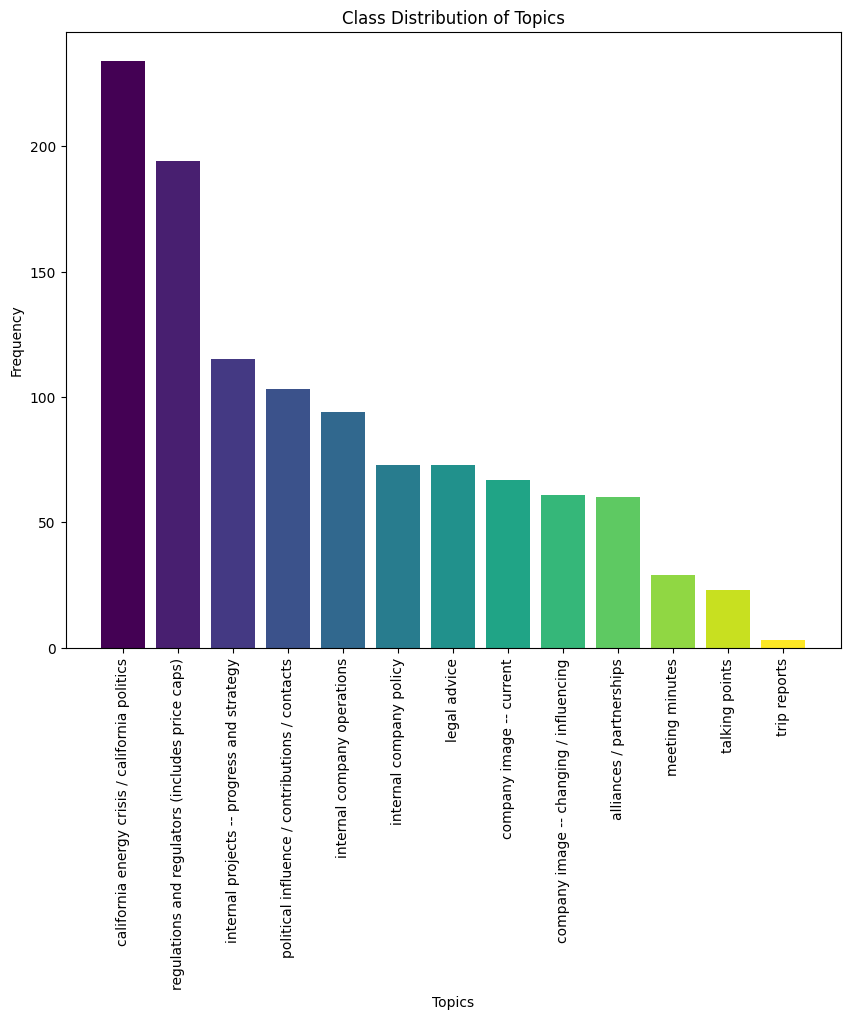

In [11]:
# Count the occurrences of each topic
topic_counts = Counter(all_email_topics)

# Sort topics by frequency
sorted_topics = sorted(topic_counts.items(), key=lambda x: x[1], reverse=True)
sorted_labels = [item[0] for item in sorted_topics]
sorted_counts = [item[1] for item in sorted_topics]

# Generate a list of colors, one for each topic
colors = plt.cm.viridis(np.linspace(0, 1, len(sorted_labels)))

# Plot class distribution
plt.figure(figsize=(10, 8))
plt.bar(sorted_labels, sorted_counts, color=colors)
plt.xlabel('Topics')
plt.ylabel('Frequency')
plt.xticks(rotation=90)  # Rotate labels to prevent overlap
plt.title('Class Distribution of Topics')
plt.show()

As you can see above, the class distribution of the dataset favors emails regarding california energy policy and regulations. However, there should be enough variety in the class distribution of the data such that we should be able to properly test the classification performance of the models.

# Benchmark of Universal Classifiers on Eron Dataset

Now that we have plotted the class distribution of the email dataset, we can now analyze the classification performance of the zero-shot models on this email dataset.

In [37]:
!pip install transformers datasets
from transformers import pipeline
from datasets import Dataset
import torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.8 MB/s eta 0:00:00


In [24]:
# Check if GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


In [25]:
# Setup DeBERTa and RoBERTa zero-shot model
deberta_zeroshot_classifier = pipeline("zero-shot-classification", model="MoritzLaurer/deberta-v3-large-zeroshot-v2.0", device=0 if device == "cuda" else -1)
roberta_zeroshot_classifier = pipeline("zero-shot-classification", model="MoritzLaurer/roberta-large-zeroshot-v2.0", device=0 if device == "cuda" else -1)

In [61]:
# Test DeBERTa and RoBERTa zero-shot model
text = get_email_thread_content('/content/drive/My Drive/Gmail Extension Senior Project/enron_with_categories/1/6178.txt')

deberta_output_single = deberta_zeroshot_classifier(text, topics, multi_label=False)
roberta_output_single = roberta_zeroshot_classifier(text, topics, multi_label=False)

# Print most confident category
print(topics[np.argmax(deberta_output["scores"])])
print(topics[np.argmax(roberta_output["scores"])])

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


regulations and regulators (includes price caps)
regulations and regulators (includes price caps)


In [33]:
all_email_contents = []
all_email_topics = []
for email_thread in email_threads:
  email_content = get_email_thread_content(email_thread[0])
  email_topics = get_email_thread_topics(email_thread[1])
  all_email_contents.append(email_content)
  all_email_topics.append(email_topics)

print(all_email_contents[0])
print(all_email_topics[0])

Message-ID: <8041754.1075853069648.JavaMail.evans@thyme>
Date: Tue, 16 Oct 2001 16:25:02 -0700 (PDT)
From: lynn.blair@enron.com
To: donna.scott@enron.com
Subject: FW: Confidential - PAA - HW & TD
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Blair, Lynn </O=ENRON/OU=NA/CN=RECIPIENTS/CN=LBLAIR>
X-To: Scott, Donna </O=ENRON/OU=NA/CN=RECIPIENTS/CN=Dscott1>
X-cc: 
X-bcc: 
X-Folder: \LBLAIR (Non-Privileged)\Blair, Lynn\Sent Items
X-Origin: Blair-L
X-FileName: LBLAIR (Non-Privileged).pst

	Here are two we did for Harry and Tangie.  Thanks. Lynn

 -----Original Message-----
From: 	Dietz, Rick  
Sent:	Saturday, September 15, 2001 5:15 PM
To:	Corman, Shelley
Cc:	Blair, Lynn
Subject:	Confidential - PAA - HW & TD

Please accept the attached Personal Achievement Award request for Harry Woodson and Tangie Dykes.  I have included both of them on the same request form since their recognition is for their contributions toward the ONEOK arbitration

In [64]:
# Create dataset of emails
email_data = {'text': all_email_contents, 'labels': all_email_topics}
email_dataset = Dataset.from_dict(email_data)

In [66]:
# Execute classification of emails
deberta_output_all = deberta_zeroshot_classifier(email_dataset['text'], topics, multi_label=False, batch_size=128)
roberta_output_all = roberta_zeroshot_classifier(email_dataset['text'], topics, multi_label=False, batch_size=128)

In [67]:
# Print first predictions
print(topics[np.argmax(deberta_output_all[0]["scores"])])
print(topics[np.argmax(roberta_output_all[0]["scores"])])

# Print number of outputs
print(len(roberta_output_all))

regulations and regulators (includes price caps)
regulations and regulators (includes price caps)
834


In [71]:
deberta_num_correct = 0
roberta_num_correct = 0

for i in range(len(deberta_output_all)):
  email_topics = all_email_topics[i]
  deberta_chosen_topic = topics[np.argmax(deberta_output_all[0]["scores"])]
  roberta_chosen_topic = topics[np.argmax(roberta_output_all[0]["scores"])]

  if deberta_chosen_topic in email_topics:
    deberta_num_correct += 1

  if roberta_chosen_topic in email_topics:
    roberta_num_correct += 1

debrta_accuracy = deberta_num_correct / len(deberta_output_all)
robrta_accuracy = deberta_num_correct / len(deberta_output_all)

print("DeBERTa accuracy: " + str(debrta_accuracy))
print("RoBERTa accuracy: " + str(robrta_accuracy))

DeBERTa accuracy: 0.23261390887290168
DeBERTa accuracy: 0.23261390887290168


It appears that the performance of both these universal classifiers is farily poor on this Enron email dataset. Both the DeBERTa and RoBERTa based models only had an accuracy of 23%. To remedy this, we can do further training on labeled email datasets, provide greater context to the models by modifying the descriptiveness of the labels, and/or switch to a more powerful NLI model such as GPT-3.